<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>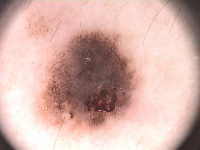</td><td>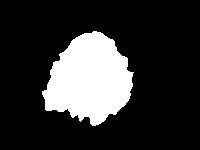</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
!ls

'[hw]semantic_segmentation.ipynb'   PH2Dataset	     PH2Dataset.zip
 __MACOSX			    PH2Dataset.rar


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [194]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [195]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [196]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [197]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

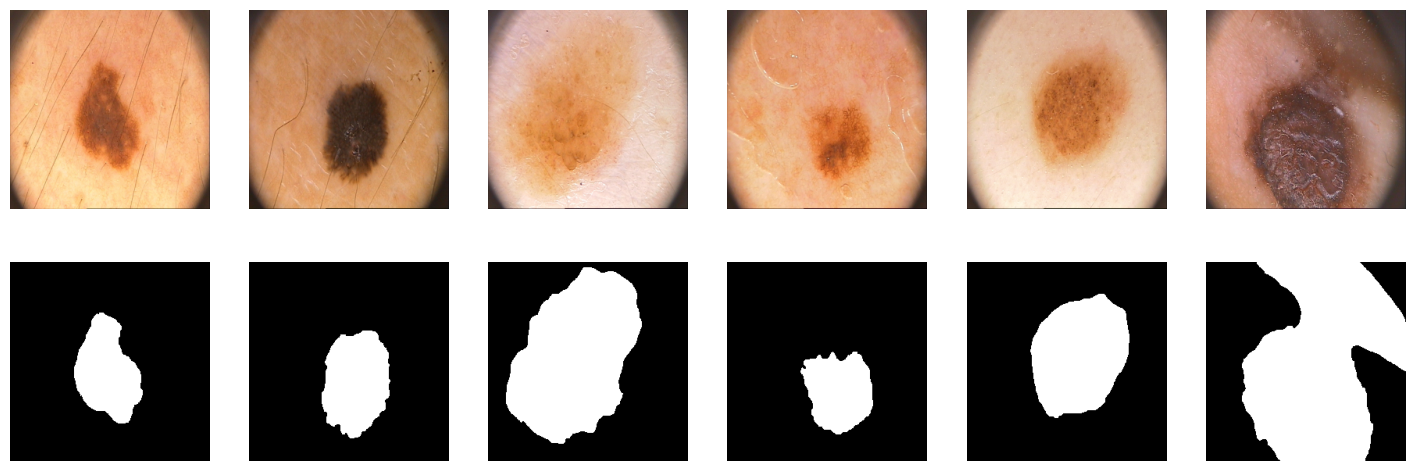

In [198]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [199]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [200]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [201]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [421]:
!nvidia-smi

Sun Nov 27 14:53:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   53C    P0   250W / 300W |  15428MiB / 16384MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [422]:
%env NVIDIA_VISIBLE_DEVICES=1
%env CUDA_VISIBLE_DEVICES=2

!echo $NVIDIA_VISIBLE_DEVICES
!echo $CUDA_VISIBLE_DEVICES

env: NVIDIA_VISIBLE_DEVICES=1
env: CUDA_VISIBLE_DEVICES=2
1
2


In [423]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

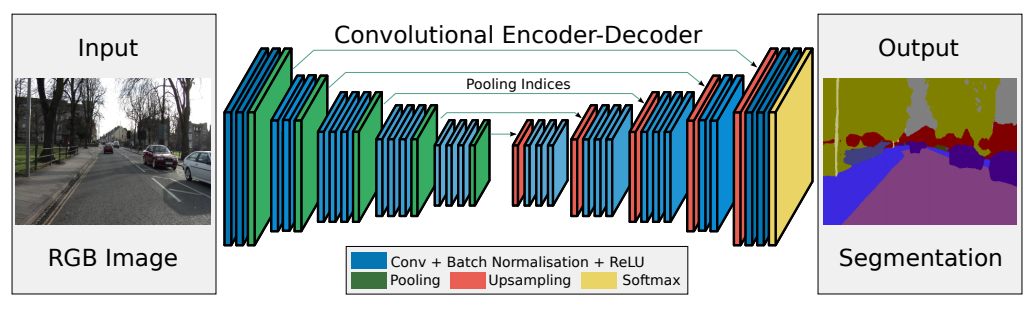

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # 256 -> 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
            
        # 16 -> 32
        self.upsample = nn.MaxUnpool2d(2, stride=2)
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
            
        # 32 -> 64
            
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
            
        # 64 -> 128
            
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
            
        # 128 -> 256
            
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, indices_0 = self.pool(self.enc_conv0(x))
        e1, indices_1 = self.pool(self.enc_conv1(e0))
        e2, indices_2 = self.pool(self.enc_conv2(e1))
        e3, indices_3 = self.pool(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample(b, indices_3))
        d1 = self.dec_conv1(self.upsample(d0, indices_2))
        d2 = self.dec_conv2(self.upsample(d1, indices_1))
        d3 = self.dec_conv3(self.upsample(d2, indices_0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

_____
$$\mathcal L_{BCE} = max(\hat y, 0) - \hat y * y + \log\left(1 + \exp(-|\hat y|\right) $$

In [18]:
from torch.nn.functional import relu

def bce_loss(y_real, y_pred):
    
    y_real = y_real.squeeze(1)
    y_pred = y_pred.squeeze(1)
    
    res = torch.mean(relu(y_pred) - y_pred * y_real + torch.log(1. + torch.exp(-torch.abs(y_pred))))
    
    return res

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [303]:
from skimage.segmentation import find_boundaries
from scipy.ndimage import distance_transform_edt as eucl_dist

def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def compute_sdm(sample_gt):
    
    pos_mask = sample_gt
    neg_mask = 1 - pos_mask
    
    pos_dist = eucl_dist(pos_mask)
    neg_dist = eucl_dist(neg_mask)
    bound = find_boundaries(pos_mask.cpu().numpy(), mode='inner').astype(np.uint8)
    
    sdm = normalize(eucl_dist(neg_mask)) - normalize(eucl_dist(pos_mask))
    sdm[seg==1] = 0
    
    return torch.tensor(sdm)

In [478]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    
    if hasattr(loss_fn, 'func') and loss_fn.func.__name__ == 'boundary_loss':
        
        with torch.no_grad():
            sdm_batches = []

            for _, Y_batch in data_tr:
                sdm_batch = []
                for sample in Y_batch:
                    sdm = compute_sdm(sample)
                    sdm_batch.append(sdm)

                sdm_batches.append(torch.stack(sdm_batch))
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        
        for idx, (X_batch, Y_batch) in enumerate(data_tr):
            # data to device
            X_batch = X_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch).cpu()
            
            if hasattr(loss_fn, 'func') and loss_fn.func.__name__ == 'boundary_loss':
                l = idx * X_batch.shape[0]
                r = l + X_batch.shape[0]
                
                loss = loss_fn(Y_batch, Y_pred, sdm=sdm_batches[l:r])
            else:
                loss = loss_fn(Y_batch, Y_pred) # forward-pass
            
            loss.backward() # backward-pass
            opt.step() # update weights
            scheduler.step()

            # calculate loss to show the user
            avg_loss += loss
            
        toc = time()
        avg_loss /= len(data_tr)
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval() # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [479]:
sigmoid = torch.sigmoid

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        
        X_batch = X_batch.to(device)
        
        Y_pred = model(X_batch).detach().cpu()
        
        scores += metric(sigmoid(Y_pred) > 0.5, Y_label.long()).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [480]:
import gc

torch.cuda.empty_cache()
gc.collect()

2069

In [481]:
model = SegNet().to(device)

In [482]:
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

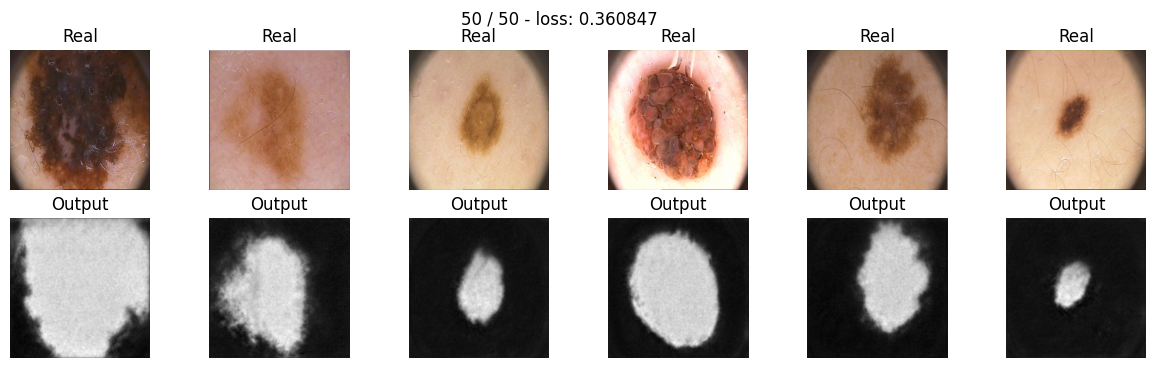

In [483]:
max_epochs = 50
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs//5, eta_min=1e-5)

train(model, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

In [484]:
score_model(model, iou_pytorch, data_val)

0.6940000057220459

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [138]:
def dice_loss(y_real, y_pred):
    num = 2 * torch.sum(y_real * y_pred, dim=(1, 2, 3))
    den = torch.sum(torch.square(y_real) + torch.square(y_pred))
    res = torch.mean(num / den)
                    
    return 1 - res

Проводим тестирование:

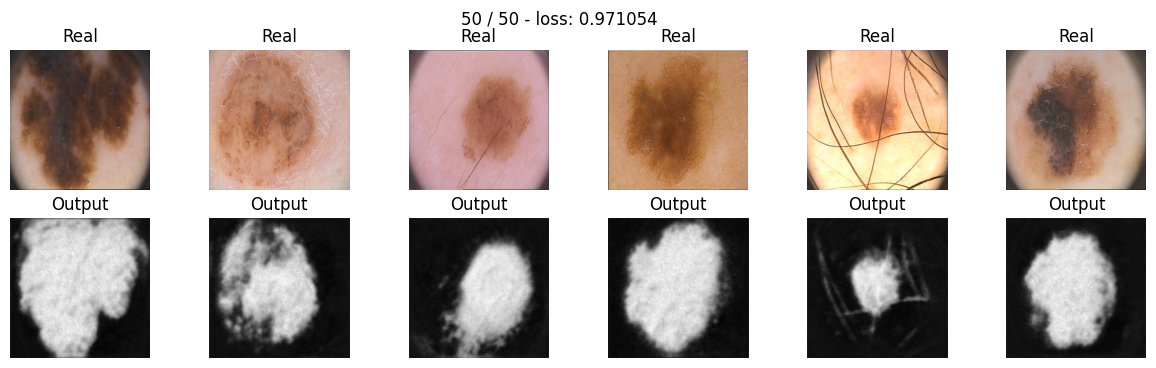

In [485]:
model_dice = SegNet().to(device)

max_epochs = 50

optimizer = AdamW(model_dice.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs//5, eta_min=1e-5)

train(model_dice, optimizer, scheduler, dice_loss, max_epochs, data_tr, data_val)

In [486]:
score_model(model_dice, iou_pytorch, data_val)

0.687999963760376

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [22]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), min=eps)  # hint: torch.clamp

    res = -torch.mean((1 - y_pred)**gamma * y_real * torch.log(y_pred + eps) + (1 - y_real) * torch.log(1 - y_pred + eps))
    
    return res

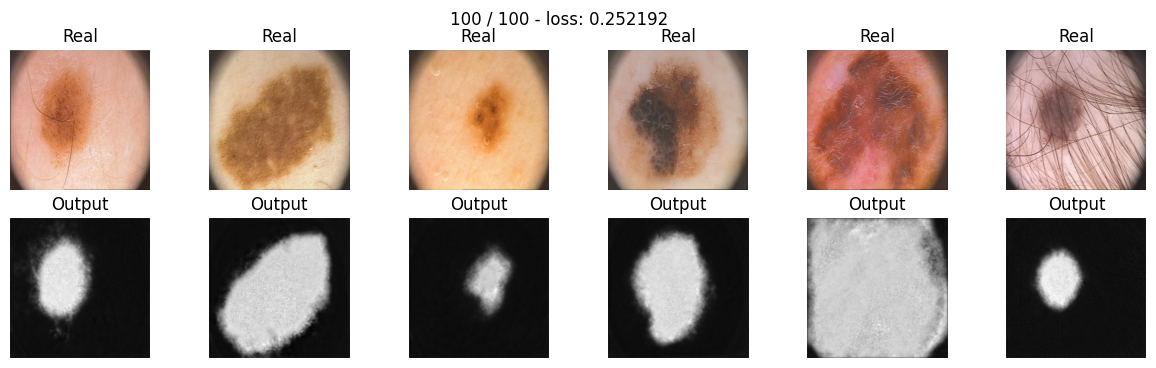

In [50]:
model_focal = SegNet().to(device)

max_epochs = 100

optimizer = AdamW(model_focal.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs//4, eta_min=1e-5)

train(model_focal, optimizer, scheduler, focal_loss, max_epochs, data_tr, data_val)

In [51]:
score_model(model_focal, iou_pytorch, data_val)

0.6199999451637268

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

В данной [статье](https://arxiv.org/abs/1812.07032) предлагается развить идею *regional* лоссов, т.е. лоссов, учитывающих пересечение по площади на идею пересечения границ, или *boundary* лосс.
![image info](./pics/boundary_loss.png)

Синим обозначается ground truth маска, красным -- модельная сегментационная маска. Давайте вместо дифференциального подходя слева, который суммирует отклонения от границ, вдоль направления нормалей, будем использовать интегральный подход справа и будем считать расстояния из всех точек предсказанной маски до ground truth границы, таким образом у точек внутри будет отрицательные значения, у нех, что вне -- положительные и у всех граничных -- 0. 

Ниже приведен пример построение так называемых *signed distance maps* для всех тренировочных данных. Ознакомившись с результатами статьи авторы пришли к выводу о том, что их лосс нельзя использовать как единственный для обучения модели, поскольку оптимум такого лосса соответствует отрицательным значениям и быстро приводит к весам, которые, проходя через softmax, зануляются, что сказывается на пустых сегментационных масках, предсказываемых моделью. Идеальный кейс по заявлению авторов заключаетсчя в балансировании regional и boundary лоссов, отдавая больший вес в начале первому и ближе к концу второму. Я же в своей реализации равно взвешиваю оба лосса, вне зависимости от эпохи для упрощения реализации.

In [351]:
def boundary_loss(y_real, y_pred, sdm, regional_loss=None):
    
    total_loss = torch.tensor(0.)
    
    if regional_loss is not None:
        total_loss += regional_loss(y_real, y_pred)
        
    elw_prod = torch.einsum('bxwh, bxwh->bxwh', y_real, sigmoid(y_pred))
    
    total_loss += elw_prod.mean()
        
    return total_loss

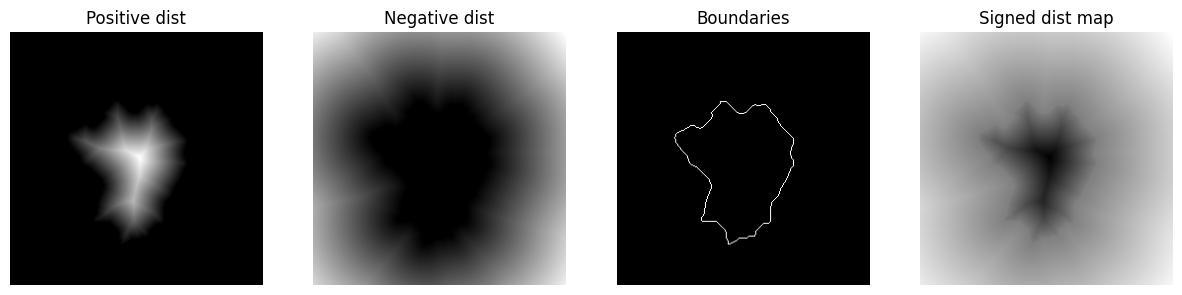

In [315]:
fig, axes = plt.subplots(ncols=4)

pos_mask = data_tr.dataset[0][1]

axes[0].imshow(eucl_dist(pos_mask)[0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('Positive dist')

neg_mask = 1 - pos_mask

axes[1].imshow(eucl_dist(neg_mask)[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('Negative dist')

seg = find_boundaries(pos_mask, mode='inner').astype(np.uint8)

axes[2].imshow(seg[0], cmap='gray')
axes[2].axis('off')
axes[2].set_title('Boundaries')

sdm = normalize(eucl_dist(neg_mask)) - normalize(eucl_dist(pos_mask))
sdm[seg==1] = 0

axes[3].imshow((sdm)[0], cmap='gray')
axes[3].axis('off')
axes[3].set_title('Signed dist map')

plt.show()

In [287]:
from functools import partial

In [352]:
multiloss = partial(boundary_loss, regional_loss=focal_loss)

In [364]:
import gc

torch.cuda.empty_cache()
gc.collect()

5436

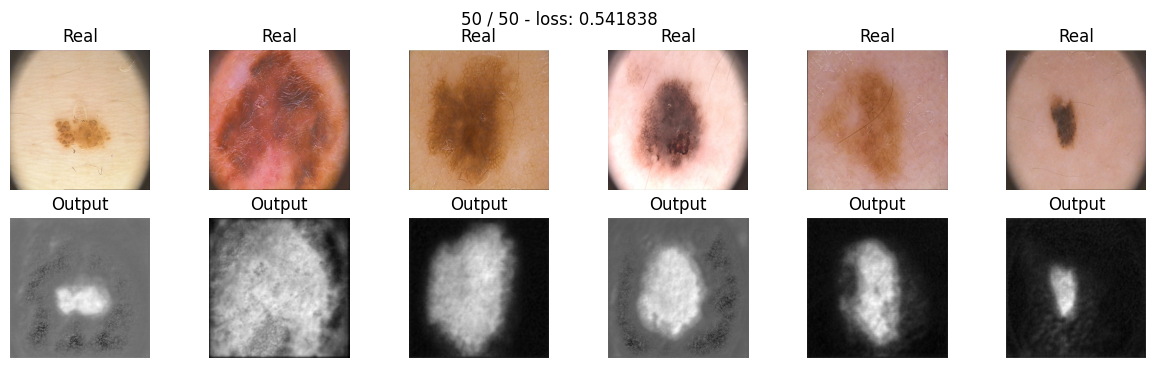

In [378]:
model_multiloss = SegNet().to(device)

max_epochs = 50

optimizer = AdamW(model_multiloss.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs//5, eta_min=1e-5)

train(model_multiloss, optimizer, scheduler, multiloss, max_epochs, data_tr, data_val)

In [379]:
score_model(model_multiloss, iou_pytorch, data_val)

0.648000031709671

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

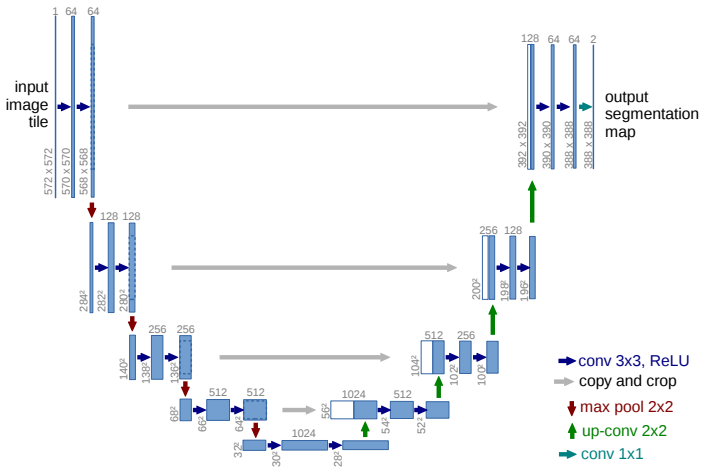

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [23]:
class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)


class DecoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Identity() if out_channels == 64 else nn.ReLU(inplace=True)
        )
        
    def forward(self, x, y):
        
        x = self.conv0(x)
        
        return self.conv1(torch.cat([x, y], dim=1))
        
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc_conv0 = EncoderBlock(in_channels=3, out_channels=64)
        self.enc_conv1 = EncoderBlock(in_channels=64, out_channels=128)
        self.enc_conv2 = EncoderBlock(in_channels=128, out_channels=256)
        self.enc_conv3 = EncoderBlock(in_channels=256, out_channels=512)
        
        self.bottleneck_conv = EncoderBlock(in_channels=512, out_channels=1024)
        
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.dec_conv0 = DecoderBlock(in_channels=1024, out_channels=512)
        self.dec_conv1 = DecoderBlock(in_channels=512, out_channels=256)
        self.dec_conv2 = DecoderBlock(in_channels=256, out_channels=128)
        self.dec_conv3 = DecoderBlock(in_channels=128, out_channels=64)
        
        self.last_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool(e0))
        e2 = self.enc_conv2(self.pool(e1))
        e3 = self.enc_conv3(self.pool(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool(e3))

        # decoder
        d0 = self.dec_conv0(self.upsample(b), e3)
        d1 = self.dec_conv1(self.upsample(d0), e2)
        d2 = self.dec_conv2(self.upsample(d1), e1)
        d3 = self.dec_conv3(self.upsample(d2), e0)
        return self.last_conv(d3)

In [24]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [25]:
# !nvidia-smi

In [26]:
unet_model = UNet().to(device)

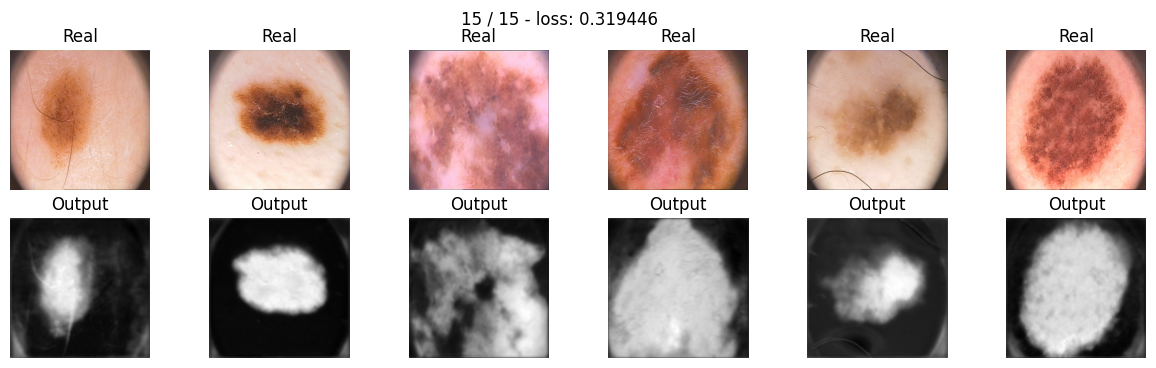

In [29]:
max_epochs = 15
optimizer = Adam(unet_model.parameters(), lr=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)

train(unet_model, optimizer, scheduler, focal_loss, max_epochs, data_tr, data_val)

In [30]:
score_model(unet_model, iou_pytorch, data_val)

0.6380000114440918

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [31]:
class EncoderBlock2(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=2, bias=False, stride=2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
        )
        
        
    def forward(self, x):
        
        feat_map = self.conv0(x)
        
        return self.conv1(feat_map), feat_map


class DecoderBlock2(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, bias=False, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Identity() if out_channels == 64 else nn.ReLU(inplace=True)
        )
        
    def forward(self, x, y):
        
        x = self.conv0(x)
        
        return self.conv1(torch.cat([x, y], dim=1))
        
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = EncoderBlock2(in_channels=3, out_channels=64)
        self.enc_conv1 = EncoderBlock2(in_channels=64, out_channels=128)
        self.enc_conv2 = EncoderBlock2(in_channels=128, out_channels=256)
        self.enc_conv3 = EncoderBlock2(in_channels=256, out_channels=512)
        
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(1024, 1024, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.dec_conv0 = DecoderBlock2(in_channels=1024, out_channels=512)
        self.dec_conv1 = DecoderBlock2(in_channels=512, out_channels=256)
        self.dec_conv2 = DecoderBlock2(in_channels=256, out_channels=128)
        self.dec_conv3 = DecoderBlock2(in_channels=128, out_channels=64)
        
        self.last_conv = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        e0, f0 = self.enc_conv0(x)
        e1, f1 = self.enc_conv1(e0)
        e2, f2 = self.enc_conv2(e1)
        e3, f3 = self.enc_conv3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(b, f3)
        d1 = self.dec_conv1(d0, f2)
        d2 = self.dec_conv2(d1, f1)
        d3 = self.dec_conv3(d2, f0)
        return self.last_conv(d3)

In [36]:
import gc

torch.cuda.empty_cache()
gc.collect()

22834

In [33]:
unet2_model = UNet2().to(device)

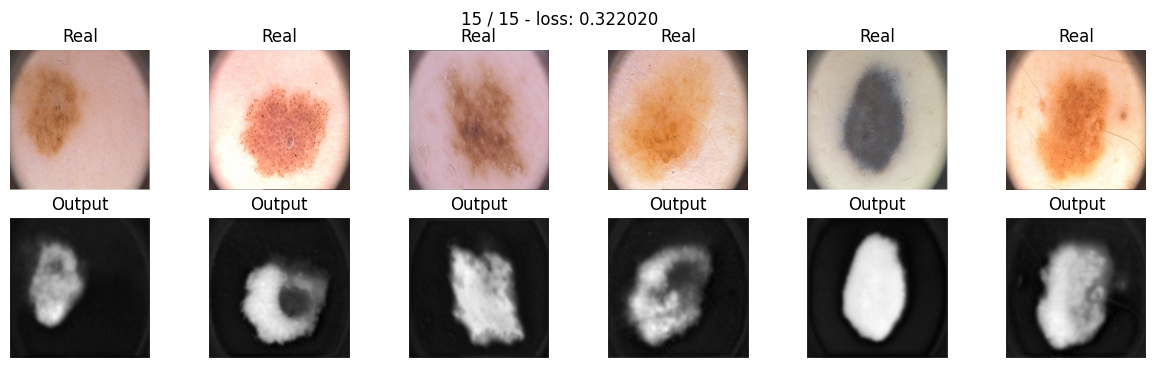

In [34]:
max_epochs = 15
optimizer = Adam(unet2_model.parameters(), lr=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)

train(unet2_model, optimizer, scheduler, focal_loss, max_epochs, data_tr, data_val)

In [35]:
score_model(unet2_model, iou_pytorch, data_val)

0.6879999935626984

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

___

Мой отчет не претендует на строго научную работу, однако в нем я хочу привести сравнительные характеристики всех моделей, обученных с разными лоссами. Моя цель не в подборе идельаных параметров каждой модели, а наоборот, в сравнении способности к обобщению при одинаковых условиях обучения.

In [573]:
models = [SegNet, UNet, UNet2]

In [590]:
loss_funcs = [bce_loss, dice_loss, focal_loss, multiloss]

In [575]:
import pandas as pd

loss_names= []

for x in loss_funcs:
    
    val = x.func.__name__ if hasattr(x, 'func') else x.__name__
    loss_names.append(val)

dsc_df = pd.DataFrame(data=None, index=loss_names, columns=[x.__name__ for x in models])

In [572]:
# df.loc['bce_loss'].loc['SegNet'] = 1
# df

,SegNet,UNet,UNet2
bce_loss,1,NaN,NaN
dice_loss,NaN,NaN,NaN
focal_loss,NaN,NaN,NaN
boundary_loss,NaN,NaN,NaN


In [624]:
def get_report(model_class, loss_funcs, data_tr, data_val, device, n_runs=5):
    dsc_list = []
                
    for loss_fn in loss_funcs:
        
        if hasattr(loss_fn, 'func') and loss_fn.func.__name__ == 'boundary_loss':
        
            with torch.no_grad():
                sdm_batches = []

                for _, Y_batch in data_tr:
                    sdm_batch = []
                    for sample in Y_batch:
                        sdm = compute_sdm(sample)
                        sdm_batch.append(sdm)

                    sdm_batches.append(torch.stack(sdm_batch)) 

        tmp_dsc_list = []
    
        for run_id in range(n_runs):

            model = model_class().to(device)            

            opt = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
            scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
            
            print(f'{model.__class__.__name__} with {loss_fn} train loss, run #{run_id}')

            for epoch in range(50):

                model.train()  

                for idx, (X_batch, Y_batch) in enumerate(data_tr):

                    X_batch = X_batch.to(device)
                    opt.zero_grad()

                    Y_pred = model(X_batch).cpu()

                    if hasattr(loss_fn, 'func') and loss_fn.func.__name__ == 'boundary_loss':
                        l = idx * X_batch.shape[0]
                        r = l + X_batch.shape[0]

                        loss = loss_fn(Y_batch, Y_pred, sdm=sdm_batches[l:r])
                    else:
                        loss = loss_fn(Y_batch, Y_pred)

                    loss.backward()
                    opt.step()
                    scheduler.step()
                     
            tmp_dsc_list.append(score_model(model, iou_pytorch, data_val))
            torch.cuda.empty_cache()
            gc.collect()
                    
        dsc_list.append(tmp_dsc_list)

    return dsc_list 

In [593]:
dsc_df

,SegNet,UNet,UNet2
bce_loss,NaN,NaN,NaN
dice_loss,NaN,NaN,NaN
focal_loss,NaN,NaN,NaN
boundary_loss,NaN,NaN,NaN


In [603]:
segnet_report = np.array(models_reports)
segnet_report.shape

(4, 5)

In [641]:
print(np.mean(segnet_report, axis=1))
print(np.std(segnet_report, axis=1))

[0.6        0.552      0.54360001 0.54400001]
[0.07840409 0.05981305 0.06659009 0.04081178]


In [ ]:
unet_report = np.array(unet_report)
unet_report.shape

In [642]:
print(np.mean(unet_report, axis=1))
print(np.std(unet_report, axis=1))

[0.66320001 0.6232     0.68399999 0.70319998]
[0.05225476 0.09784558 0.05114685 0.02254241]


In [651]:
unet2_report = np.array(unet2_report)
unet2_report.shape

(4, 5)

In [653]:
print(np.mean(unet2_report, axis=1))
print(np.std(unet2_report, axis=1))

[0.64559999 0.56599998 0.66160001 0.56920001]
[0.09148902 0.09206086 0.09502336 0.0830672 ]


In [652]:
# tmp_report = get_report(UNet2, loss_funcs, data_tr, data_val, device, n_runs=5)

In [673]:
for rep, model in zip([segnet_report, unet_report, unet2_report], models):
    
    means = np.mean(rep, axis=1)
    stds = np.std(rep, axis=1)
    
    for i, loss in enumerate(loss_names):
        dsc_df.loc[loss, model.__name__] = f'{np.round(means[i], 2)} ± {np.round(stds[i], 2)}'

Результаты ниже были получены для 5 усредненных запусков каждой из конфигураций вида: 'модель' + 'лосс'. Как можно видеть из таблицы, лучшие результаты показала модель **UNet** с фокальным ***regional_loss***'ом и ***boundary_loss***'ом. Худше всего с задачей справилась **SegNet** с ***dice_loss***.

In [674]:
dsc_df

,SegNet,UNet,UNet2
bce_loss,0.6 ± 0.08,0.66 ± 0.05,0.65 ± 0.09
dice_loss,0.55 ± 0.06,0.62 ± 0.1,0.57 ± 0.09
focal_loss,0.54 ± 0.07,0.68 ± 0.05,0.66 ± 0.1
boundary_loss,0.54 ± 0.04,0.7 ± 0.02,0.57 ± 0.08


В качестве улучшений хотелось бы преложить использовать **UNet** со связкой ***focal_loss***+***boundary_loss*** и обновлением весов по расписанию, как я описывал выше.